source: http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# Transfer Learning tutorial

In [14]:
import torch
from torch.autograd import Variable
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import time
import os

## Load Data

In [2]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = './dataset/hymenoptera_data'

In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                     for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=4)
                  for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

### Visualize a few images

In [5]:
%matplotlib inline

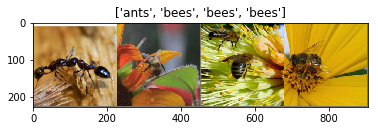

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [7]:
inputs.shape

torch.Size([4, 3, 224, 224])

In [8]:
out.shape

torch.Size([3, 228, 906])

## Training the model

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)  
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
            
            running_loss = 0.0
            running_corrects = 0
            
            for data in dataloaders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                    
                optimizer.zero_grad()
                
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss +=loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model    

### Visualizing the model predictions

In [26]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
            
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[i]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                return

## Finetuning the convnet

In [19]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0809 Acc: 0.8648
val Loss: 0.0678 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.0806 Acc: 0.8648
val Loss: 0.0518 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.0785 Acc: 0.8566
val Loss: 0.0504 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.0908 Acc: 0.8402
val Loss: 0.0589 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.0741 Acc: 0.8689
val Loss: 0.0510 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.0867 Acc: 0.8811
val Loss: 0.0609 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.0823 Acc: 0.8525
val Loss: 0.0654 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.0848 Acc: 0.8238
val Loss: 0.0616 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.0649 Acc: 0.8730
val Loss: 0.0529 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.0726 Acc: 0.9098
val Loss: 0.0619 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.0515 Acc: 0.9180
val Loss: 0.0644 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.0968 Acc: 0.8484
val Loss: 0.0521 Acc: 0.9150

Ep

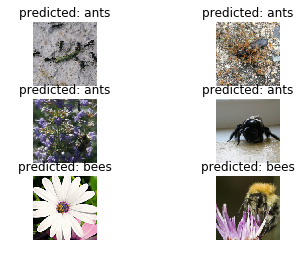

In [27]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

In [30]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad=False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()
    
criterion = nn.CrossEntropyLoss()

# ovserve that only parameters of finial layer
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [31]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1417 Acc: 0.6762
val Loss: 0.0696 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.1624 Acc: 0.7049
val Loss: 0.0502 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.1376 Acc: 0.7623
val Loss: 0.0505 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.1204 Acc: 0.8074
val Loss: 0.0420 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.0898 Acc: 0.8443
val Loss: 0.0453 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.1132 Acc: 0.7992
val Loss: 0.0478 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.0944 Acc: 0.8402
val Loss: 0.0420 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.0967 Acc: 0.8197
val Loss: 0.0428 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.1012 Acc: 0.8197
val Loss: 0.0421 Acc: 0.9673

Epoch 9/24
----------
train Loss: 0.0937 Acc: 0.8525
val Loss: 0.0462 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.1016 Acc: 0.8074
val Loss: 0.0421 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.0793 Acc: 0.8525
val Loss: 0.0420 Acc: 0.9477

Ep

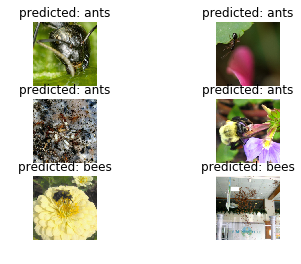

In [32]:
visualize_model(model_conv)
plt.ioff()
plt.show()